Proyecto Final para la materia **Desarrollo de Sistemas de Inteligencia Artificial**, enfocado en crear una Red Neuronal Convolucional (CNN) para clasificación de imágenes.

# **Parte A. Código Fuente**


* ***cifar10***: Imágenes a color (32 x 32 píxeles) de 10 clases (aviones, autos, pájaros, gatos, etc.)

##Importacion de librerias

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Librerias importadas")

Librerias importadas


## Pre-procesamiento de datos

Aquí es donde "limpiamos" y organizamos los datos.

**cifar10.load_data()**:

* ¿Qué hace?: Descarga las 60,000 imágenes desde los servidores de Google/Keras.

* Detalle: Divide automáticamente en dos grupos: (train) para estudiar y (test) para el examen final.

**astype('float32') / 255.0 (Normalización)**:

* ¿Qué hace?: Las imágenes digitales tienen valores de color de 0 a 255. Esta línea divide todo por 255 para que los valores queden entre 0 y 1.

* ¿Por qué es vital?: Es un requisito explícito del proyecto. A las redes neuronales no les gustan los números grandes; aprenden mucho más rápido y convergen mejor si los números son pequeños (entre 0 y 1).

**to_categorical(..., 10) (One-Hot Encoding)**:

* ¿Qué hace?: Transforma la etiqueta numérica simple (ej: 5 que significa "Perro") en un vector de ceros y unos (ej: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]).

* ¿Por qué?: Como la salida de la red tiene 10 neuronas (una por clase), necesitamos que la respuesta correcta tenga el mismo formato para poder compararlas matemáticamente.

**X_train[:val_split], X_val (División de Validación)**:

* ¿Qué hace?: "Robamos" una parte de los datos de entrenamiento (10,000 imágenes) para crear un tercer conjunto: Validación.

* ¿Por qué?: Es obligatorio.

* Train: Para que el modelo aprenda.

* Validation: Para que nosotros vigilemos si está aprendiendo bien durante el proceso (y activar el EarlyStopping).

* Test: Para evaluar al final de todo.

In [ ]:
# Cargar el dataset CIFAR-10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

# Normalización: Convertir valores de píxeles de 0-255 a 0-1
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encoding de las etiquetas (necesario para clasificación multiclase)
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# División en Entrenamiento y Validación
# Tomamos los primeros 40,000 para train y 10,000 para validación
val_split = 40000
X_train, X_val = X_train_full[:val_split], X_train_full[val_split:]
y_train, y_val = y_train_full[:val_split], y_train_full[val_split:]

print(f"Entrenamiento: {X_train.shape}, Validación: {X_val.shape}, Test: {X_test.shape}")
print("Datos descargados y pre-procesados")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Entrenamiento: (40000, 32, 32, 3), Validación: (10000, 32, 32, 3), Test: (10000, 32, 32, 3)
Datos descargados y pre-procesados


## Construccion del modelo CNN

**model = models.Sequential()**
  * ¿Qué hace? Crea un contenedor vacío o una "caja" donde iremos apilando las capas de tu red neuronal, una tras otra, en orden secuencial.

(model.add...) - Aquí armamos el "cerebro" de la IA capa por capa.


**layers.RandomFlip/Rotation/Zoom (Data Augmentation)**:

* ¿Qué hace?: Gira o voltea las fotos aleatoriamente antes de mostrárselas al modelo.

* ¿Para qué sirve?: Evita que el modelo "memorice" una foto exacta. Lo obliga a reconocer un avión aunque esté inclinado.


**layers.Conv2D(...)**:

* ¿Qué hace?: Son los "ojos". Pasa filtros sobre la imagen para detectar características: bordes, colores, formas redondas, etc.

**layers.BatchNormalization()**:

* ¿Qué hace?: Es un "estabilizador". Mantiene los valores matemáticos dentro de rangos manejables.

* ¿Para qué sirve?: Hace que la red aprenda mucho más rápido y sea más estable.


**layers.MaxPooling2D((2, 2))**:

* ¿Qué hace?: Reduce el tamaño de la imagen a la mitad (de 32x32 pasa a 16x16, etc.), quedándose solo con la información más importante (el píxel con valor máximo).


**layers.Dropout(0.X)**:

* ¿Qué hace?: "Apaga" aleatoriamente un porcentaje (20%, 30%) de neuronas en cada paso.

* ¿Para qué sirve?: Es vital contra el Overfitting. Obliga a la red a no depender de una sola neurona para tomar una decisión.


**layers.Flatten()**:

* ¿Qué hace?: Convierte el mapa de características (que es 3D: alto, ancho, canales) en una fila larga de números (1D) para que la parte final del cerebro pueda clasificar.

In [ ]:
model = models.Sequential()

# A. Data Augmentation (Para mitigar overfitting)
# Esto altera aleatoriamente las imágenes durante el entrenamiento
model.add(layers.RandomFlip("horizontal", input_shape=(32, 32, 3)))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))

# B. Bloque Convolucional 1
# Filtros: 32, Kernel: 3x3, Activación: ReLU
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization()) # Mejora la estabilidad
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) # Reduce dimensión espacial
model.add(layers.Dropout(0.2)) # Apaga neuronas al azar (Regularización)

# C. Bloque Convolucional 2
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# D. Bloque Convolucional 3 (Para capturar patrones más complejos)
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

# E. Clasificación (Parte Densa)
model.add(layers.Flatten()) # Aplanamiento
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Regularización L2
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax')) # Salida Softmax

print("Modelo construido")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo construido


## Compilacion y entrenamiento

Aquí configuramos cómo va a aprender el modelo.


**optimizer='adam'**:  Es el algoritmo matemático que ajusta los "pesos" de la red. Adam es el estándar hoy en día porque ajusta la velocidad de aprendizaje automáticamente.

**loss='categorical_crossentropy'**: Es la forma de medir el error. Se usa "categorical" porque tenemos varias clases (avión, auto, perro...), no solo sí/no.

**Bloque de Callbacks (EarlyStopping)**

* EarlyStopping(...):

  * ¿Qué hace?: Vigila el entrenamiento. Si ve que el modelo deja de mejorar durante 10 épocas (patience=10), detiene el entrenamiento automáticamente.

  * ¿Para qué sirve?: Ahorra tiempo y evita que el modelo empiece a empeorar (overfitting) por entrenar de más.

In [ ]:
# Optimizador Adam recomendado
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) # Métrica accuracy/exactitud

# Callbacks: EarlyStopping para detener si no mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Iniciando entrenamiento...")
history = model.fit(X_train, y_train,
                    epochs=50, # Máximo de épocas (parará antes si es necesario)
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Iniciando entrenamiento...
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.2156 - loss: 2.5332 - val_accuracy: 0.4127 - val_loss: 1.7925
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3665 - loss: 1.8781 - val_accuracy: 0.2847 - val_loss: 2.8976
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4221 - loss: 1.6965 - val_accuracy: 0.5080 - val_loss: 1.4754
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4738 - loss: 1.5790 - val_accuracy: 0.5076 - val_loss: 1.6913
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5189 - loss: 1.4742 - val_accuracy: 0.5102 - val_loss: 1.6482
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5519 - loss: 1.4013 - val_accuracy: 0.5664 - val_loss: 1.3969
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5805 - loss: 1.3391 - val_accuracy: 0.6425 - val_loss: 1.1803
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy

## Evaluacion del modelo

Una vez entrenado el modelo, este bloque mide qué tan bueno es realmente en situaciones nuevas.

**model.evaluate(X_test, y_test)**:

* ¿Qué hace?: Toma el modelo ya entrenado y lo pone a prueba con las imágenes de test (que el modelo NO vio antes).

* ¿Por qué?: Nos da el Accuracy Real. Si tienes un accuracy alto en entrenamiento pero bajo aquí, significa que el modelo "memorizó" (Overfitting). Si ambos son altos (como tu 79%), el modelo aprendió de verdad.

**test_loss (0.7867)**: Representa el valor de la función de coste (Categorical Crossentropy) en el examen final . Matemáticamente, mide la discrepancia entre la distribución de probabilidad predicha por el modelo y la etiqueta real.

En otras palabras, un valor de 0.78 es bajo y positivo. Indica que, incluso cuando el modelo se equivoca, no suele estar "muy seguro" de su error, y cuando acierta, lo hace con alta confianza. Si este número fuera muy alto (ej. 3.0 o 4.0), significaría que el modelo está muy confundido.

In [ ]:
# Evaluar en conjunto de test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nAccuracy final en Test: {test_acc*100:.2f}%")
print(f"Loss final en Test: {test_loss:.4f}")


Accuracy final en Test: 74.21%
Loss final en Test: 0.9066


#**Parte B. Graficos**

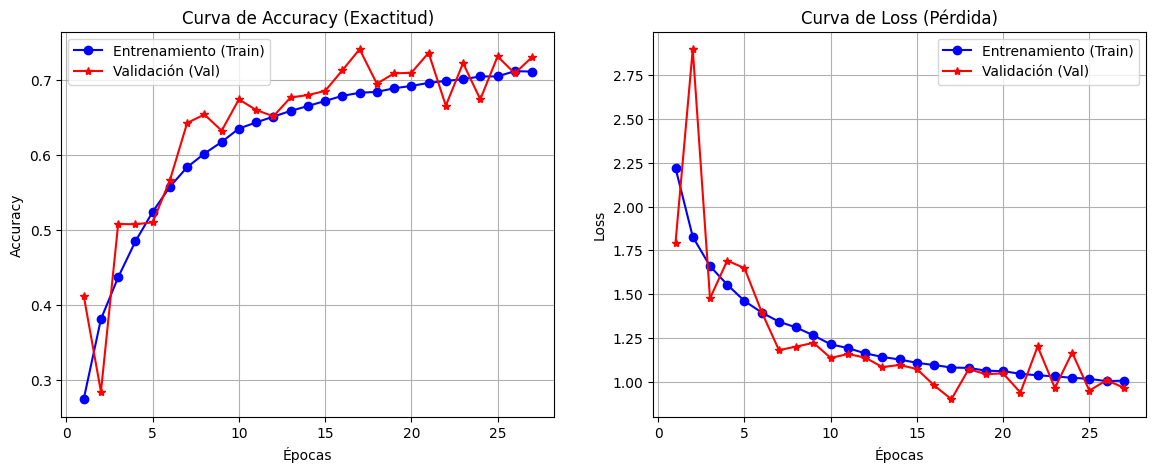

In [ ]:
# Gráficos de Loss y Accur
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Gráfico de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Entrenamiento (Train)')
    plt.plot(epochs, val_acc, 'r*-', label='Validación (Val)')
    plt.title('Curva de Accuracy (Exactitud)')
    plt.xlabel('Épocas')     # Eje X: Tiempo de entrenamiento
    plt.ylabel('Accuracy')   # Eje Y: Porcentaje de aciertos
    plt.legend()
    plt.grid(True)

    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Entrenamiento (Train)')
    plt.plot(epochs, val_loss, 'r*-', label='Validación (Val)')
    plt.title('Curva de Loss (Pérdida)')
    plt.xlabel('Épocas')     # Eje X: Tiempo de entrenamiento
    plt.ylabel('Loss')       # Eje Y: Error acumulado
    plt.legend()
    plt.grid(True)

    plt.show()

plot_history(history)


**plot_history(history)**: Esta función toma el objeto history, que es un registro que guarda TensorFlow paso a paso durante el entrenamiento. Su trabajo es extraer los datos de métricas por cada época y visualizarlos en dos gráficos comparativos.


* Extracción de datos: Las primeras líneas (acc = ..., val_acc = ...) sacan las listas de números que indican qué tan bien le fue al modelo en cada vuelta (época).


**Curvas (Train vs. Val)**:

* Línea Azul (bo-): Representa el Entrenamiento (Train). Es el rendimiento del modelo sobre las fotos que sí pudo estudiar.

* Línea Roja (r*-): Representa la Validación (Val). Es el rendimiento sobre fotos que no estudió . Esta es la línea más importante.

---

**Interpretación de los Gráficos**

* Gráfico A: Curva de Accuracy (Exactitud)
  * Eje Y (Vertical): Porcentaje de aciertos (de 0 a 1). Cuanto más alto, mejor.

 * Lo ideal seria que ambas líneas suban rápidamente al principio y luego estabilizarse (hacerse planas).


> **Observamos que la exactitud de validación (línea roja) aumenta progresivamente hasta llegar al 79%, lo que indica que el modelo está aprendiendo patrones generalizables y no solo ruido.**

* Gráfico B: Curva de Loss (Pérdida/Error)
  * Eje Y (Vertical): Error de cálculo. Cuanto más bajo, mejor.

  * Ambas líneas deben bajar. Es normal que la línea azul (entrenamiento) baje más que la roja.

  * Señal de Alerta (Overfitting): Si en algún momento la línea roja empieza a subir mientras la azul sigue bajando, significa que el modelo empezó a memorizar. Gracias a las técnicas de regulación (Dropout y Data Augmentation), es probable que la línea roja se mantenga estable o baje suavemente, lo cual es excelente.

> **Vemos que tanto la línea de entrenamiento como la de validación descienden progresivamente, lo cual confirma que la red está minimizando su error de manera efectiva a lo largo de las épocas.**

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


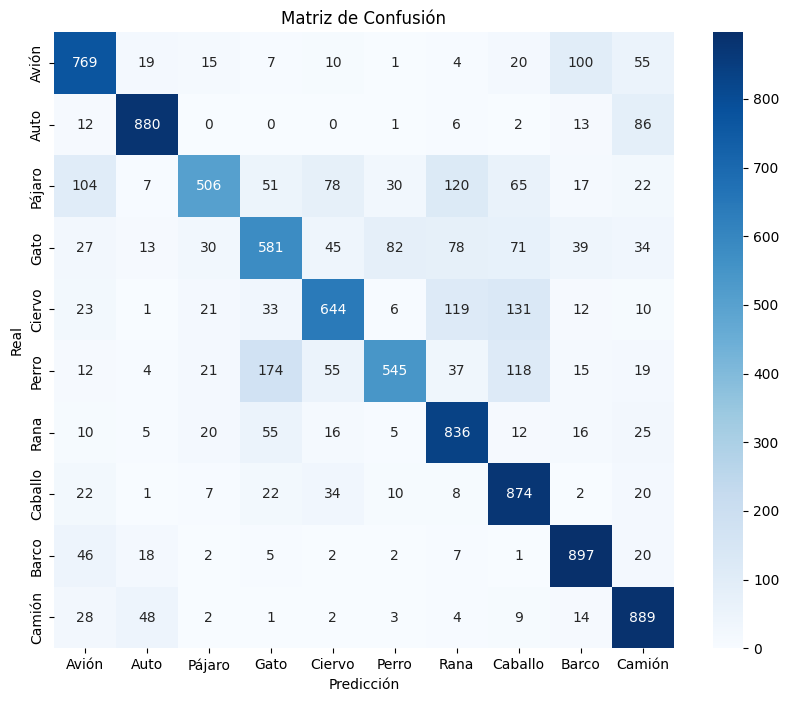

In [ ]:
# Matriz de Confusión
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
class_names = ['Avión', 'Auto', 'Pájaro', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

**model.predict(X_test)**:

* ¿Qué hace?: Pide al modelo que mire las imágenes de prueba y lance sus probabilidades (ej: "estoy 90% seguro que es un avión, 5% pájaro, etc.").

**np.argmax(..., axis=1)**:

* ¿Qué hace?: Traduce las probabilidades a una decisión final. Si la neurona 0 (Avión) tiene el valor más alto, argmax devuelve 0. Esto nos permite comparar "lo que dijo la red" (y_pred_classes) contra "lo que es en realidad" (y_true).

**confusion_matrix y sns.heatmap**:


* ¿Qué hace?: Crea una tabla visual donde las filas son la realidad y las columnas son las predicciones.

**Interpretación**:

* La diagonal principal (de arriba-izquierda a abajo-derecha) son los aciertos. Queremos colores oscuros ahí.

* Los cuadros fuera de la diagonal son errores. Ayuda a decir cosas como: "Mi modelo confunde mucho los Gatos con los Perros, pero es excelente identificando Autos".
* Los números que vemos dentro de cada cuadro de la matriz representan la cantidad exacta de imágenes del conjunto de prueba (Test Set) que cayeron en esa categoría específica.